# Vehicle Classification using Machine Learning

This notebook implements a vehicle classification system using multiple machine learning models and computer vision techniques. It processes images using HOG (Histogram of Oriented Gradients) and LBP (Local Binary Patterns) features, then trains and compares different classifiers.


## 1. Import Required Libraries


In [125]:
import os
import cv2
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.feature import local_binary_pattern
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import multiprocessing as mp
import joblib
import pandas as pd



## 2. Helper Functions
### 2.1 Data Management Functions


In [126]:
def save_features_to_csv(features, labels, filename):
    df = pd.DataFrame(features)
    df['label'] = labels
    df.to_csv(filename, index=False)
    print(f"Features saved to {filename}")


def load_features_from_csv(filename):
    df = pd.read_csv(filename)
    labels = df['label'].values
    features = df.drop('label', axis=1).values
    return features, labels



### 2.2 Image Processing Functions


In [127]:
def process_image(args):
    """Process a single image (helper for multiprocessing)."""
    img_path, class_idx = args
    try:
        img_path = os.path.normpath(img_path)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image: {img_path}")
            return None, None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (64, 64))
        return img, class_idx
    except Exception as e:
        print(f"Error processing {img_path}: {str(e)}")
        return None, None

def load_images_from_folder(folder, class_labels):
    """Load and process images from a folder."""
    folder = os.path.normpath(folder)
    
    image_paths = []
    for idx, label in enumerate(class_labels):
        class_folder = os.path.join(folder, label)
        if not os.path.exists(class_folder):
            print(f"Warning: Folder not found - {class_folder}")
            continue
            
        for ext in ['*.jpg', '*.jpeg']:
            pattern = os.path.join(class_folder, ext)
            image_paths.extend([(os.path.normpath(f), idx)
                              for f in glob.glob(pattern)])
    
    if not image_paths:
        raise ValueError(f"No images found in {folder}")
        
    print(f"Found {len(image_paths)} images...")
    
    # Process images sequentially with progress bar
    images = []
    labels = []
    for img_path, class_idx in tqdm(image_paths, desc="Processing images"):
        try:
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (64, 64))
                images.append(img)
                labels.append(class_idx)
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")
            continue
    
    if not images:
        raise ValueError("No valid images were processed successfully")
        
    return np.array(images), np.array(labels)



### 2.3 Feature Extraction Functions


In [128]:
# def extract_features_parallel(images, feature_func):
#     """Extract features from images using multiprocessing."""
#     with mp.Pool(processes=mp.cpu_count()) as pool:
#         features = list(tqdm(pool.imap(feature_func, images), total=len(images)))
#     return np.array(features)

def extract_features_parallel(images, feature_func):
    print(f"Extracting features from {len(images)} images...")
    
    features = []
    for img in tqdm(images, desc="Extracting features"):
        features.append(feature_func(img))
    return np.array(features)

def extract_hog_features(img):
    hog = cv2.HOGDescriptor((64, 64), (16, 16), (8, 8), (8, 8), 9)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img
    return hog.compute(img).flatten()


def extract_lbp_features(image, radius=3, n_points=24):
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype('float') / (hist.sum() + 1e-7)
    return hist



### 2.4 Model Training and Evaluation Functions


In [129]:
def train_and_evaluate_model(model, X_train, X_val, y_train, y_val, model_name, class_labels, results):
    print(f"\nTraining {model_name}...")
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    
    val_accuracy = accuracy_score(y_val, y_pred)
    val_precision = precision_score(y_val, y_pred, average='macro')
    val_recall = recall_score(y_val, y_pred, average='macro')
    val_f1 = f1_score(y_val, y_pred, average='macro')

    print(f"{model_name} Validation Metrics:")
    print(f"Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Precision: {val_precision * 100:.2f}%")
    print(f"Recall: {val_recall * 100:.2f}%")
    print(f"F1-Score: {val_f1 * 100:.2f}%")
    print("\nDetailed Classification Report:")
    print(classification_report(y_val, y_pred, target_names=class_labels))

    conf_matrix = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels, cbar=False)
    plt.title(f"Confusion Matrix - {model_name}", fontsize=16)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("True", fontsize=14)
    plt.tight_layout()
    plt.show()

    results[model_name] = {
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1,
        'conf_matrix': conf_matrix,
        'model': model
    }

    return model

def plot_model_comparison(results):
    model_names = list(results.keys())
    metrics = {
        'Accuracy': [results[model]['val_accuracy'] * 100 for model in model_names],
        'Precision': [results[model]['val_precision'] * 100 for model in model_names],
        'Recall': [results[model]['val_recall'] * 100 for model in model_names],
        'F1-Score': [results[model]['val_f1'] * 100 for model in model_names]
    }
    
    plt.figure(figsize=(15, 8))
    x = np.arange(len(model_names))
    width = 0.2  # Width of bars
    
    bars = []
    for i, (metric, values) in enumerate(metrics.items()):
        position = x + (i - 1.5) * width
        bar = plt.bar(position, values, width, label=metric)
        bars.append(bar)
    
    plt.title('Model Performance Metrics Comparison', fontsize=16, fontweight='bold')
    plt.ylabel('Percentage (%)', fontsize=14)
    plt.xlabel('Models', fontsize=14, labelpad=10)
    plt.xticks(x, model_names, fontweight='bold')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    for bar_group in bars:
        for bar in bar_group:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height,
                    f'{round(height, 1)}%',
                    ha='center', va='bottom',
                    fontsize=12)

    plt.tight_layout()
    plt.show()

### 2.5 Prediction and Visualization Function


In [130]:
def predict_and_visualize(image_path, model, scaler, pca, class_labels):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, (64, 64))

    hog_features = extract_hog_features(img_resized)
    lbp_features = extract_lbp_features(img_resized)
    features = np.hstack((hog_features, lbp_features))

    features_scaled = scaler.transform(features.reshape(1, -1))
    features_pca = pca.transform(features_scaled)

    prediction = model.predict(features_pca)
    prediction_proba = model.predict_proba(features_pca)[0] if hasattr(model, 'predict_proba') else None

    plt.subplot(1, 2, 2)
    if prediction_proba is not None:
        y_pos = np.arange(len(class_labels))
        plt.barh(y_pos, prediction_proba)
        plt.yticks(y_pos, class_labels)
        plt.xlabel('Probability')
        plt.title('Prediction Probabilities')
    else:
        plt.text(0.5, 0.5, f'Predicted Class:\n{class_labels[prediction[0]]}',
                 ha='center', va='center', fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return class_labels[prediction[0]]



## 3. Main Process
### 3.1 Data Loading and Feature Extraction


In [131]:
train_data_path = '../datasets/train'
val_data_path = '../datasets/val'
train_features_path = '../features/train_features.csv'
val_features_path = '../features/val_features.csv'

if not os.path.exists('../features'):
    os.makedirs('../features')

class_labels = [d for d in os.listdir(train_data_path)
                if os.path.isdir(os.path.join(train_data_path, d))]
print(f"Found classes: {class_labels}")

if os.path.exists(train_data_path) and os.path.exists(val_features_path):
    print("Loading precomputed features...")
    X_train, y_train = load_features_from_csv(train_features_path)
    X_val, y_val = load_features_from_csv(val_features_path)
else:
    print("Loading and processing images...")
    X_train, y_train = load_images_from_folder(train_data_path, class_labels)
    X_val, y_val = load_images_from_folder(val_data_path, class_labels)

    X_train_hog = extract_features_parallel(X_train, extract_hog_features)
    X_val_hog = extract_features_parallel(X_val, extract_hog_features)
    X_train_lbp = extract_features_parallel(X_train, extract_lbp_features)
    X_val_lbp = extract_features_parallel(X_val, extract_lbp_features)

    X_train = np.hstack((X_train_hog, X_train_lbp))
    X_val = np.hstack((X_val_hog, X_val_lbp))
    save_features_to_csv(X_train, y_train, train_features_path)
    save_features_to_csv(X_val, y_val, val_features_path)


Found classes: ['bus', 'family sedan', 'fire engine', 'heavy truck', 'jeep', 'minibus', 'racing car', 'SUV', 'taxi', 'truck']
Loading precomputed features...


### 3.2 Feature Preprocessing


In [132]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)


### 3.3 Model Training and Evaluation



Training SVM...
SVM Validation Metrics:
Accuracy: 76.00%
Precision: 77.05%
Recall: 76.00%
F1-Score: 75.88%

Detailed Classification Report:
              precision    recall  f1-score   support

         bus       0.72      0.90      0.80        20
family sedan       0.67      0.90      0.77        20
 fire engine       0.82      0.70      0.76        20
 heavy truck       0.88      0.70      0.78        20
        jeep       0.67      0.80      0.73        20
     minibus       0.76      0.65      0.70        20
  racing car       0.75      0.60      0.67        20
         SUV       0.94      0.85      0.89        20
        taxi       0.68      0.65      0.67        20
       truck       0.81      0.85      0.83        20

    accuracy                           0.76       200
   macro avg       0.77      0.76      0.76       200
weighted avg       0.77      0.76      0.76       200



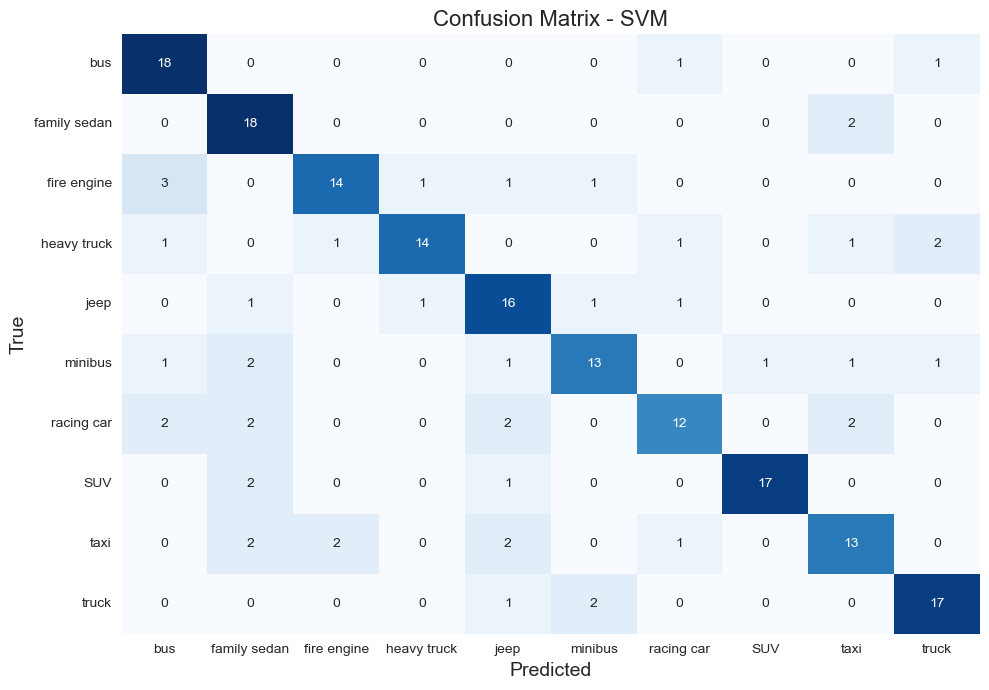


Training KNN...
KNN Validation Metrics:
Accuracy: 68.50%
Precision: 70.20%
Recall: 68.50%
F1-Score: 67.95%

Detailed Classification Report:
              precision    recall  f1-score   support

         bus       0.79      0.55      0.65        20
family sedan       0.80      0.80      0.80        20
 fire engine       0.65      0.65      0.65        20
 heavy truck       0.68      0.75      0.71        20
        jeep       0.59      0.85      0.69        20
     minibus       0.90      0.45      0.60        20
  racing car       0.50      0.60      0.55        20
         SUV       0.79      0.95      0.86        20
        taxi       0.56      0.45      0.50        20
       truck       0.76      0.80      0.78        20

    accuracy                           0.69       200
   macro avg       0.70      0.68      0.68       200
weighted avg       0.70      0.69      0.68       200



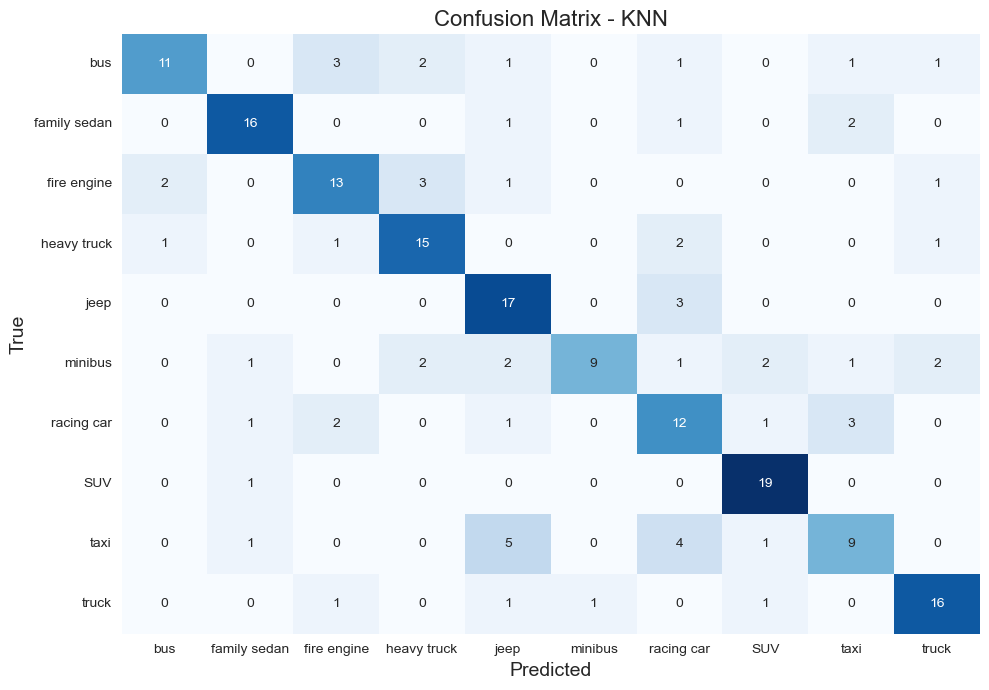


Training Naive Bayes...
Naive Bayes Validation Metrics:
Accuracy: 67.50%
Precision: 67.92%
Recall: 67.50%
F1-Score: 66.55%

Detailed Classification Report:
              precision    recall  f1-score   support

         bus       0.63      0.60      0.62        20
family sedan       0.67      0.90      0.77        20
 fire engine       0.72      0.65      0.68        20
 heavy truck       0.71      0.60      0.65        20
        jeep       0.75      0.75      0.75        20
     minibus       0.67      0.50      0.57        20
  racing car       0.73      0.40      0.52        20
         SUV       0.66      0.95      0.78        20
        taxi       0.60      0.60      0.60        20
       truck       0.67      0.80      0.73        20

    accuracy                           0.68       200
   macro avg       0.68      0.67      0.67       200
weighted avg       0.68      0.68      0.67       200



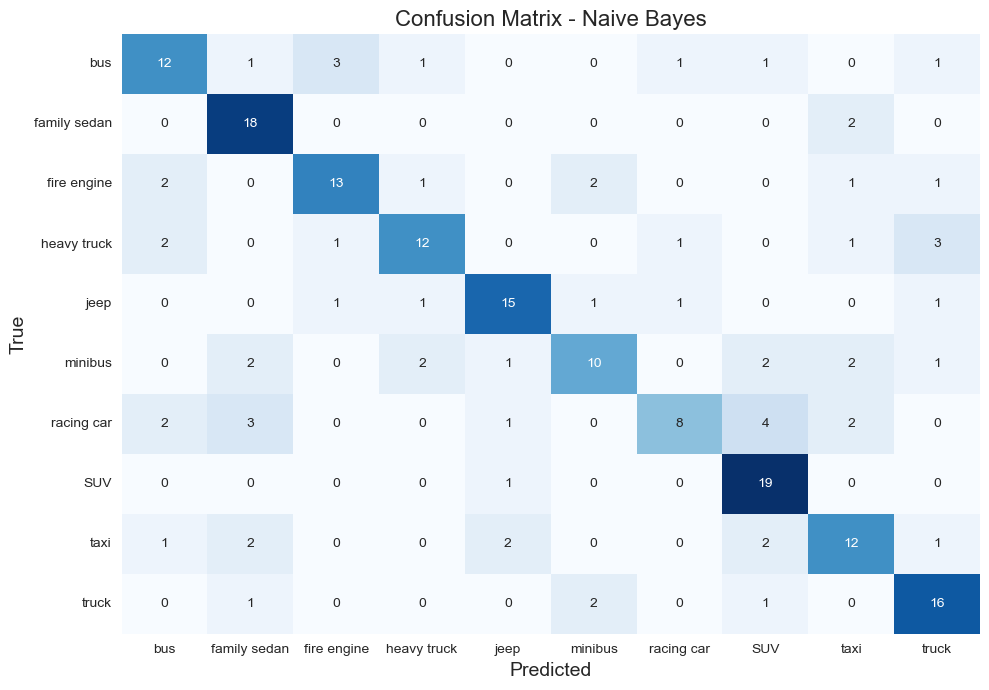

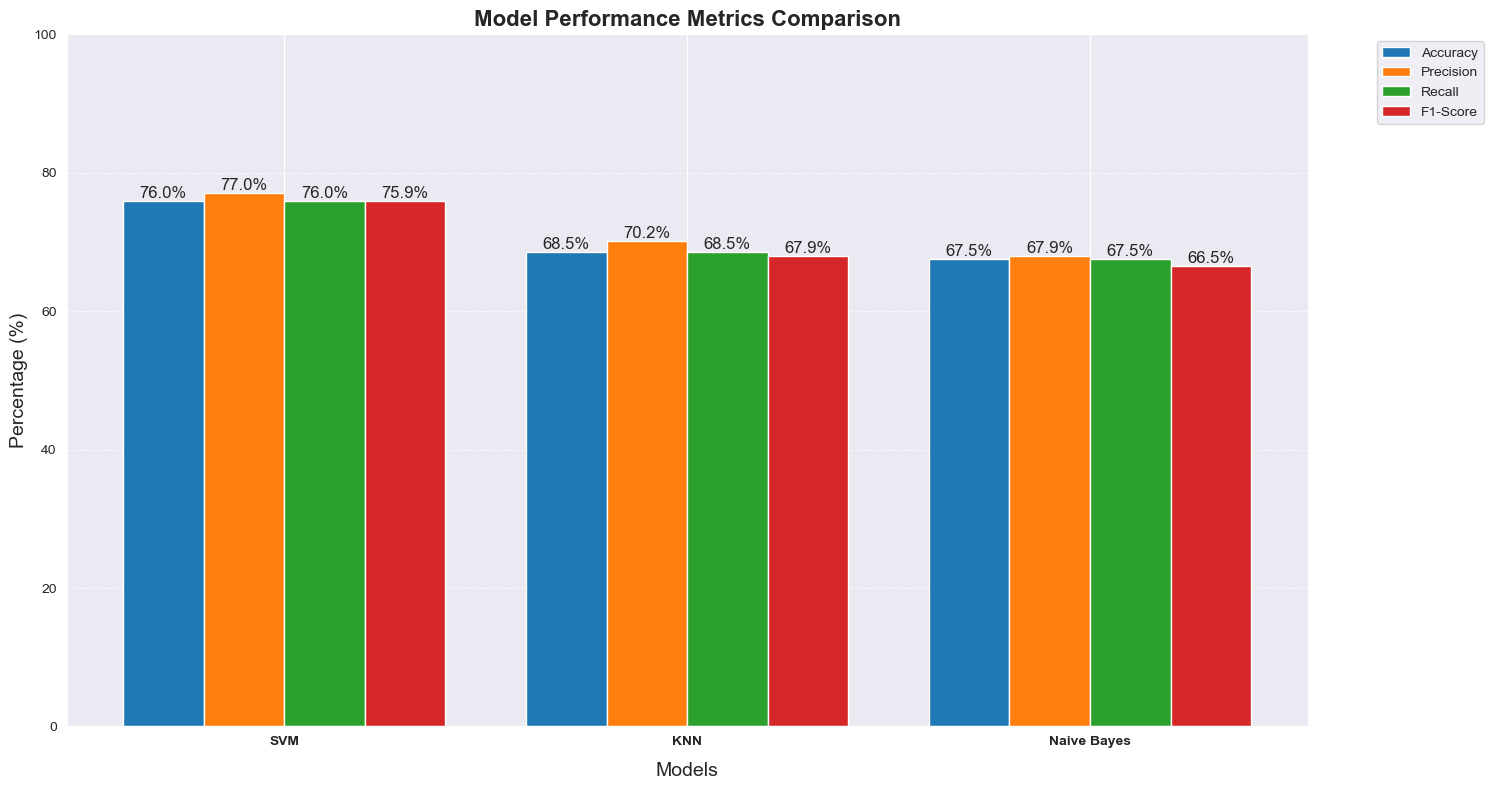

In [133]:
models = {
    'SVM': GridSearchCV(svm.SVC(probability=True),
                        {'C': [0.1, 1, 10],
                         'gamma': ['scale'],
                         'kernel': ['rbf']},
                        cv=3),
    'KNN': GridSearchCV(KNeighborsClassifier(),
                        {'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']},
                        cv=3),
    'Naive Bayes': GaussianNB()
}

results = {}
for model_name, model in models.items():
    if isinstance(model, GridSearchCV):
        model.fit(X_train_pca, y_train)
        best_model = model.best_estimator_
        train_and_evaluate_model(best_model, X_train_pca, X_val_pca,
                                 y_train, y_val, model_name, class_labels, results)
    else:
        train_and_evaluate_model(model, X_train_pca, X_val_pca,
                                 y_train, y_val, model_name, class_labels, results)

plot_model_comparison(results)


### 3.4 Get Best Model and Make Predictions


In [134]:
best_model_name = max(results.keys(), key=lambda k: results[k]['val_accuracy'])
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name}")
print(f"Best model accuracy: {results[best_model_name]['val_accuracy']*100:.2f}%")



Best model: SVM
Best model accuracy: 76.00%


### 3.5 Example Usage of Prediction

Below is an example of how to use the trained model to predict the class of a new image.


In [1]:
test_image_path = '../datasets/val/SUV/1c8ca620a06bf9ad124c29c180d95a6b.jpg'
prediction = predict_and_visualize(test_image_path, best_model, scaler, pca, class_labels)
print(f"\nPredicted vehicle class: {prediction}")



NameError: name 'predict_and_visualize' is not defined

## 4. Saving the Model and Preprocessors

In [136]:
if not os.path.exists('../models_preprocessors'):
    os.makedirs('../models_preprocessors')

best_model_save_path = f"../models_preprocessors/{best_model_name}_Classifier.joblib"
scaler_save_path = '../models_preprocessors/feature_scaler.joblib'
pca_save_path = '../models_preprocessors/pca_transformer.joblib'

joblib.dump(best_model, best_model_save_path)
joblib.dump(scaler, scaler_save_path)
joblib.dump(pca, pca_save_path)

print("Model and preprocessors saved successfully!")


Model and preprocessors saved successfully!


## 5. Loading and Using the Saved Model
 
To load and use the saved model later:


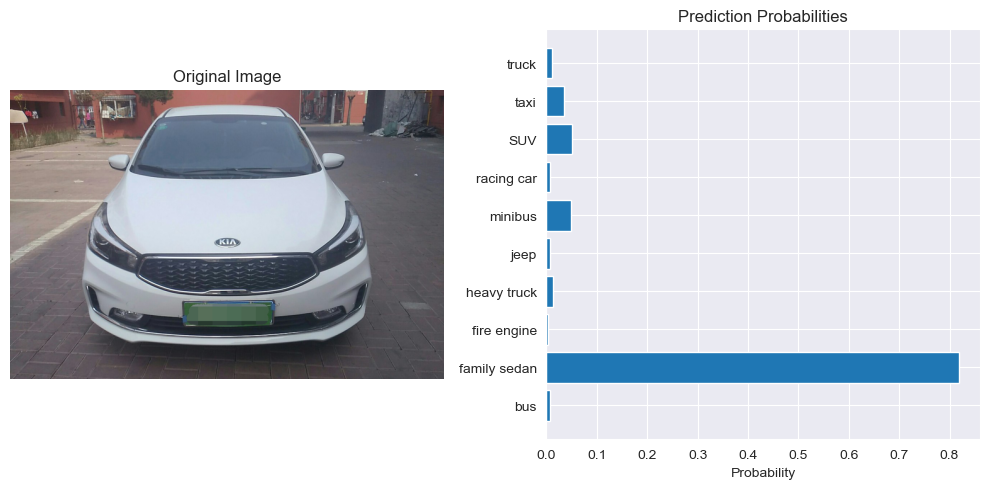


Predicted vehicle class: family sedan


In [143]:
loaded_model = joblib.load(best_model_save_path)
loaded_scaler = joblib.load(scaler_save_path)
loaded_pca = joblib.load(pca_save_path)

test_image_path = '../datasets/val/family sedan/98b83106dcaeeb585913fb59c8525757.jpg'
prediction = predict_and_visualize(test_image_path, 
                                 loaded_model, 
                                 loaded_scaler, 
                                 loaded_pca, 
                                 class_labels)
print(f"\nPredicted vehicle class: {prediction}")

## 6. Conclusion

This notebook demonstrates a complete pipeline for vehicle classification:
1. Image processing and feature extraction using HOG and LBP
2. Feature preprocessing with standardization and PCA
3. Model training and evaluation with multiple classifiers
4. Prediction visualization for new images